In [1]:
import numba
from numba import jit,njit
import numpy as np

In this notebook, the signature mean-variance optimization is implemented. And it is compared to the previous implementation.

### Brief Description of the Optimization Process

Aim: Given an expected signature `ES`, we want to find the mean-variance strategy described in [1] and `mean_variance.ipynb` in the same folder.

Notation:

We define the linear functional for weights of asset $i$ as $\sum_{|w|\leq n} a^i_{w} w$, where $n$ is the truncation level

$\prec$ is the right half shuffle product and $*$ represents the shuffle product. 

$A^i$ where $A$ is a set means the cartesian product of $A$ and itself for $i$ times. 

$p(\cdot)$ is the function maps a word $a_1\dots a_n$ to its position in a 1-d array returned by common signature computation functions (like `iisignautre` https://pypi.org/project/iisignature/ and `signatory` https://pypi.org/project/signatory/)

By integration on $\ell$, we mean the operation $\ell\prec \mathbf{i}$ for some letter $\mathbf{i}$.

Step:

1. Compute the abstract(symbolic) expression of $(w_1\prec\mathbf{i})*(w_2\prec\mathbf{j})$ and store the result in a dictionary with keyword the length of $w_1$ and $w_2$(Section 1);
2. Compute the coefficents of $a^i_{w_1}a^j_{w_2}$ in the suquare of the integration. Initialize X2_ij=np.zeros(N,N), with $N=\frac{d^m-1}{d-1}$.

        for all w1,w2 in U_{i=0}^n {1,\dots,d}^i{

            indices = Plug w1,w2 into the dictionary of corresponding length obtained in 1.

            for index in indices:
            
                X2_ij[p(w1),p(w2)] += ES[p(index)]
            }

3. Compute the coefficeints of $a^i_{w_1}$ in the integration by:
    
    Initialize R_i = np.zeros(N), with $N=\frac{d^m-1}{d-1}$

        for all w1,w2 in U_{i=0}^n {1,\dots,d}^i{

            indices = $w\prec \mathbf{i}$

            for index in indices:
        
                R_i[p(w1),p(w2)] += ES[p(index)]
                }
            
4. Get the total variance of the portofolio w.r.t a set of coefficients $\{c_i|i=1,..,n\}$ where $c_i=\{a^i_w|w\in\bigcup_{i=0}^n \{1,\dots,d\}^{i}\}$ as:

        result = 0

        for i,j in range(dim):

            result += c_i^T X2_ij c_j^T - (R_i c_i) * (R_j c_j)



By concatenate $\{c_i|i=1,..,n\}$ into a single array `c`, we would have the better form:

\begin{align*}
    \min_{c\in \mathbb{R}^{dN}} \ \ & c^T \Sigma_{sig} c \\
        &Ac = b\\
        &Bc > 0_d
\end{align*}

where $\Sigma_{sig} = \begin{pmatrix}
    X2\_11 & X2\_12 &\dots &X2\_1d\\
    \vdots & \vdots &\dots &X2\_2d\\
    X2\_d1 & X2\_d2 &\dots &X2\_dd\\
\end{pmatrix}-RR^T$ with R=[R_1,...,R_d],

$A =  \begin{pmatrix}
    ES& ES &\stackrel{\text{d times}}{\dots} &ES\\
    R\_1 &R\_2 &\dots &R\_d
\end{pmatrix}$, $b = [1,r]^T$ with $r$ the expected return.

$B = \begin{pmatrix}
    ES & 0 &\stackrel{\text{d-1 times}}{\dots} &0\\
    0 & ES &\stackrel{\text{d-2 times}}{\dots} &0\\
    \vdots &\dots & \ddots  &0\\
    0 &\dots  &\stackrel{\text{d-1 times}}{\dots} &ES
\end{pmatrix}$

This coincides with the form introuced in [1].

Finally, we solve the optimization problem and get the optimal set of coefficients.

#### Advantages of the new implementation:

1. The code is much faster compared to the previous version (more than 600 times faster for paths with 3 channels truncated at level 3! And the difference increases rapidly when truncated level and number of channels increases)

2. Can benefit from parallelization, vectorization and accerlation on GPU. 

3. It is also intutive since every coefficents of each $a^i_w$ is extracted and listed in an arrary with a clear index corresponding, so every linear functionals could be written as matrix multiplications

4. It is also considered to be general enough and space is left for further extensions (although less straightforward than the old one)

5. The code is much cleaner after expected signatures are computed.



#### Disadvantages of the new implementation:
1. The operations on the words are very intuitive and may need to redefine a function for substitution for every different operations. So not very user-friendly

2. Defining new operations is not as straightforward as the previous implementation does (could be solved when a class of operations are defined).

### 0. Some Useful Functions

In [2]:
@njit([numba.int32(numba.int32,numba.int32)])
def length_of_signature(dim,level):
    """Length of signature of paths with `dim` channels at level `level`."""
    return (dim**level-1)//(dim-1)

@njit([numba.int32(numba.int32[:],numba.int32)])
def convert_indices2_position_in_signature(indices,dim):
    """ Given a word [a_1,a_2,...,a_n], get its position in a 1-d array returned by 
        common signature computation functions(like iisignautre[1] and signatory[2]).
        [1] https://pypi.org/project/iisignature/
        [2] https://pypi.org/project/signatory/
    """
    if len(indices)==0:
        return 0
    n = len(indices)
    index = 0
    # position at the level the indices lie in
    for i in range(n):
        index += indices[i]*dim**(n-i-1)
    level = len(indices)
    # add the number of elements in previous levels
    index += length_of_signature(dim,level)
    return index

In [3]:
"""Implementation of Shuffle and Half Shuffle Products. Could be replaced by other implementations."""
import copy
class Tree:
    def __init__(self, data):
        self.children = []
        self.data = data
        self.list = [[],[]]
        self.number = 2

def _get_paths(t, paths=None, current_path=None):
    if paths is None:
        paths = []
    if current_path is None:
        current_path = []

    current_path.append(t.data)
    if len(t.children) == 0:
        paths.append(current_path)
    else:
        for child in t.children:
            _get_paths(child, paths, list(current_path))
    return paths

def half_shuffle(x):
    """ Input: an iterable objects of lists l1,l2,..,ln
        Return: l1 \prec (l2 \prec (ln-1 \prec ln))))))"""
    for i in range(len(x)):
        x[i] = x[i][::-1]
    x0 = x[0].pop()
    root = Tree(x0)
    root.list = x
    # 
    stack = [root]
    while stack:
        current_node = stack.pop()
        for n in range(current_node.number):
            if current_node.list[n]:
                node_list = copy.deepcopy(current_node.list)
                node = Tree(node_list[n].pop())
                node.number = max([n+2,current_node.number])
                node.number = min([node.number,len(current_node.list)])
                node.list = node_list
                current_node.children.append(node)
        for node in current_node.children:
            stack.append(node)

    paths = _get_paths(root)

    return paths
    
def shuffle(x):
    """ Input: an iterable objects of lists l1,l2,..,ln
        Return l1*l2*...*ln
    """
    for i in range(len(x)):
        x[i] = x[i][::-1]
    paths = []
    for i in range(len(x)):
        x_c = copy.deepcopy(x)
        x0 = x_c[i].pop()
        root = Tree(x0)
        root.list = x_c

        stack = [root]
        while stack:
            current_node = stack.pop()
            for n in range(len(x)):
                if current_node.list[n]:
                    node_list = copy.deepcopy(current_node.list)
                    node = Tree(node_list[n].pop())
                    node.list = node_list
                    current_node.children.append(node)
            for node in current_node.children:
                stack.append(node)

        paths += _get_paths(root)

    return paths

In [4]:
""" Generate cartesian product of a numpy array with repeats.
    The code is from Hadrien Titeux in stackoverflow 
    https://stackoverflow.com/questions/57128975/cartesian-product-in-numba. 
    It can be replaced by itertools.poroduct"""

@njit(numba.int32[:,:](numba.int32[:]))
def cproduct_idx(sizes: np.ndarray):
    """Generates ids tuples for a cartesian product"""
    assert len(sizes) >= 2
    tuples_count  = np.prod(sizes)
    tuples = np.zeros((tuples_count, len(sizes)), dtype=np.int32)
    tuple_idx = 0
    # stores the current combination
    current_tuple = np.zeros(len(sizes))
    while tuple_idx < tuples_count:
        tuples[tuple_idx] = current_tuple
        current_tuple[0] += 1
        # using a condition here instead of including this in the inner loop
        # to gain a bit of speed: this is going to be tested each iteration,
        # and starting a loop to have it end right away is a bit silly
        if current_tuple[0] == sizes[0]:
            # the reset to 0 and subsequent increment amount to carrying
            # the number to the higher "power"
            current_tuple[0] = 0
            current_tuple[1] += 1
            for i in range(1, len(sizes) - 1):
                if current_tuple[i] == sizes[i]:
                    # same as before, but in a loop, since this is going
                    # to get run less often
                    current_tuple[i + 1] += 1
                    current_tuple[i] = 0
                else:
                    break
        tuple_idx += 1
    return tuples

@njit
def cartesian_product(*arrays):
    sizes = [len(a) for a in arrays]
    sizes = np.asarray(sizes, dtype=np.int8)
    tuples_count  = np.prod(sizes)
    array_ids = cproduct_idx(sizes)
    tuples = np.zeros((tuples_count, len(sizes)))
    for i in range(len(arrays)):
        tuples[:, i] = arrays[i][array_ids[:, i]]
    return tuples

@njit
def cartesian_product_repeat(array, repeat):
    sizes = [len(array) for _ in range(repeat)]
    sizes = np.asarray(sizes, dtype=np.int32)
    tuples_count  = np.prod(sizes)
    array_ids = cproduct_idx(sizes)
    tuples = np.zeros((tuples_count, len(sizes)),dtype=np.int32)
    for i in range(repeat):
        tuples[:, i] = array[array_ids[:, i]]
    return tuples

### 1. Compute Operations on Words

The idea of implementing operations on words (like concatenation by another word, shuffle product, half shuffle product and composition of these) is to first perform the operation abstractly(symbolically) and then plug the concrete words into the symbolically result. 

For example, to compute an operation $O$ on two words $w_1,w_2$, we first compute $O(11\stackrel{\text{m times}}{\cdots}1,22\stackrel{\text{n times}}{\cdots}2)$, where $m,n$ is the length of the words as operands. Then, we replace 1's in all result words by letters in $w_1$ and replace 2's by letters in $w_2$ in order. This would give $O(w_1,w_2)$. This could be extend to operations on multiple words, by computing $O(\{k\stackrel{|w_k|\text{ times}}{\cdots}k\}_{k=1,\dots,m})$ and replace $k$'s by letters in $w_k$ in order. 

Note the bioperation may include some operations with other words. For simple operations, like $O_{ij}=(w_1 \prec i)*(w_2 \prec j)$ where $\mathbf{i},\mathbf{j}$ are two letters. We may simply concate $-1$ to $11\stackrel{\text{m times}}{\cdots}1$ and $-2$ to $22\stackrel{\text{m times}}{\cdots}2$, and then compute their shuffle product. After that, just replace 1 by letter in $w_1$ and 2 by $w_2$ as before, but additionally replace -1 by $\mathbf{i}$ and -2 by $\mathbf{j}$.

We could also use more complicated structure to specify the external words(Not recommand!). For example, let $O_{* w_3,w_4}(w_1,w_2):= (w_1 * w_3) * (w_2 * w_4)$. We may use $(-1,(w_3)_1),(-1,(w_3)_2),\dots$ to represent $w_3$ and $(-2,(w_4)_1),(-2,(w_4)_2),\dots$ for $w_4$. A better way is to treat them as multi-input operands: $O(w_1,w_2,w_3,w_4)$. 

Thus, it is believed that most word operations could be achieved in these ways.

## Extensions:

A big advantage of this method is that the input and output are both nd_arrays, and the shape of output arrays is fixed (we may know it simply from the abstract example pre-comouted). We may make it vectorised. Hence, in our later example, we may send $0000, 0001, ..., 2222$ and get an array of all the results of their concatenated shuffle products! It is hard to achieve this in `numba`, but may be easier in `jax` by setting static argumnets with `@partial`

In [5]:
""" Here defines the used word operations: shuffle product, and first cancatenate a word representing 
    integration along one of the member path of the process, and then take shuffle product with another
    integrated paths."""

# shuffle product
def word_shuffle_product(level1,level2):
    """ Return a dictionary with '{i}{j}' as the keyword, where i, j are the length
        of the two word-operands, and is from 0 to `level1`\`level2` respectively. 
    """
    word_shuffle_dict = numba.typed.Dict.empty(key_type=numba.types.unicode_type,value_type=numba.types.int32[:,:])
    for i in range(1,level1):
        for j in range(1,level2):
            word_shuffle_dict[f'{i}{j}'] = np.array(shuffle([[1 for _ in range(i)],[2 for _ in range(j)]]),dtype=np.int32)
    for i in range(level1):
        word_shuffle_dict[f'{i}0'] = np.ones((1,i),dtype=np.int32)
    for i in range(1,level2):
        word_shuffle_dict[f'0{i}'] = np.ones((1,i),dtype=np.int32)
    return word_shuffle_dict

# integrate(concatenate a letter) and shuffle
def word_concatenate_shuffle(level1,level2):
    """ Return a dictionary with '{i}{j}' as the keyword, where i, j are the length
        of the two word-operands, and is from 0 to `level1`\`level2` respectively.
        The value of 'ij' should be the output of 1...1(i times)[-1] \shuffle 2...2(j times)[-2].
    """
    word_concatenate_shuffle_dict = numba.typed.Dict.empty(key_type=numba.types.unicode_type,value_type=numba.types.int32[:,:])
    for i in range(level1):
        for j in range(level2):
            # shuffle product between 1...1[-1] and 2...2[-2] 
            word_concatenate_shuffle_dict[f'{i}{j}'] = np.array(shuffle([[1 for _ in range(i)]+[-1],[2 for _ in range(j)]+[-2]]),dtype=np.int32)
    return word_concatenate_shuffle_dict

In [6]:
@jit(nopython=True)
#@vectorize([numba.float64(numba.int32[:,:],numba.float64[:],numba.int32[:],numba.int32,numba.int32)], target='parallel')
def apply_bioperation_to_word(x,signature,word_operation,dim,level,*o):
    """Given a word, return the position in the signature according to a pre-computed abstract word operation,
        I didn't see the way to generalize it, so user may require to define it every time for different operations.
        (like this is in fact defined for `word_concatenate_shuffle`)
        But it may be generalized in some way, although it is not necessary to do that(could be taken place by multiple inputs operation
        The generalization to multiple inputs is straightfoward!

        Arguments:
        x: an array of shape (level[0]+level[1],). Concatenated by word1 and word2
        signature: an array of shape (N,) N=(dim^m-1)(dim-1) the expected signature
        word_operation: an array obtained from functions like `word_concatenate_shuffle`[level1,level2].
            It contains  1's,2's,.. and other stuff (like -1's,-2's,...)
        dim: int dimension of the paths
        level: a tuple (level1,level2), the level of two words
        """
    result = 0
    # get the position of the word in signature
    i1 = convert_indices2_position_in_signature(x[:level[0]],dim)
    i2 = convert_indices2_position_in_signature(x[level[0]:],dim)

    for k in range(len(word_operation)):
        xx = word_operation[k]
        
        indices = np.zeros(len(xx),dtype=np.int32)
        indices[np.where(xx==1)] = x[:level[0]] # replace 1 by letters in w1
        indices[np.where(xx==2)] = x[level[0]:] # replace 2 by letters in w2
        indices[np.where(xx==-1)] = o[0] # replace -1 by m
        indices[np.where(xx==-2)] = o[1] # replace -2 by n

        index = convert_indices2_position_in_signature(indices,dim)
        #print(convert_indices2_position_in_signature(indices,dim))
        result += signature[index]
    return ((i1,i2),result)

@njit
def concatenate_a_letter_to_words(x,signature,dim,m):
    """Given a word, return the position of the word in signature and the corresponding coefficients"""
    i = convert_indices2_position_in_signature(x,dim) # get the position of the word in signature
    indices = np.concatenate((x,np.array([m],dtype=np.int32))) # get the indices

    # read the elements corresponding to the indices in the signature
    result = signature[convert_indices2_position_in_signature(indices,dim)] 
    return (i,result)

In [7]:
@jit(nopython=True,parallel=True)
def squared_integration_functional(signature,word_operation_dict,dim,level,m,n):
    """ Return the coefficeints matrix of a^m_p(w)a^n_p(w) for w in W^d_m(A), in 
        (l_m \prec m) * (l_n \prec n) where  W^d_m(A) is the set of words of 
        dimension d up to length m. 
        
        Arguments:
        -----------------------------
        word_operation_dict: dict   a dictionary containing expression of w_i, w_j with keywords 'ij'
        m,n: int    the specific channel 
        """
    sig_len = length_of_signature(dim,level) # length of signature at (level, dim)
    weights = np.zeros((sig_len,sig_len)) # (l_m < m) * (l_n < n) = sum weights_ij (a^m_(w_1) a^n_(w_2))
    for i in range(level):
        for j in range(level):
            if i+j ==0:
                # a^m_0 a^n_0 (m*n)
                ii1 = convert_indices2_position_in_signature(np.array([m,n],dtype=np.int32),dim) 
                ii2 = convert_indices2_position_in_signature(np.array([n,m],dtype=np.int32),dim)
                weights[0,0] = signature[ii1]+signature[ii2]
                continue
            elif i+j == 1:
                generator = np.array([p for p in range(dim)],dtype=np.int32).reshape(dim,1)
            else:
                generator = cartesian_product_repeat(np.arange(dim),i+j)
            for k in range(len(generator)):
                x = generator[k]
                # a^m_x1 a^n_x2 (x1 * x2), ii = (p(x1),p(x2), es = sum S()_(x1 * x2)
                ii, es = apply_bioperation_to_word(x,signature,word_operation_dict[f'{i}{j}'],dim,(i,j),m,n)

                weights[ii[0],ii[1]] = es
    return weights

def get_sig_variance(signature,word_operation_dict,dim,level):
    """ Get the coefficeints of total variance by block maztrixs (X2_ij)_{1<= i,j <= d}
        Hence the total square of the return is a.T@X2@a, where a_p(w) is the collection 
        of coefficeints of w."""
    sig_len = length_of_signature(dim,level)
    weights = np.zeros((sig_len*dim,sig_len*dim))
    for m in range(dim):
        for n in range(dim):
            weights[m*sig_len:(m+1)*sig_len,n*sig_len:(n+1)*sig_len] = squared_integration_functional(signature,word_operation_dict,dim,level,m,n)
    return weights
        

@jit(nopython=True,parallel=True)
def integration_functional_coeff(signature,dim,level,m):
    """ Return the coefficeints vectors R_m of a^m_p(w) for w in W^d_m(A) in expected returns. 
        Hence E[l_m(S(X))] = R_m @ a, where a_p(w) is the collection of coefficeints of w"""
    coeff = np.zeros(length_of_signature(dim,level))

    coeff[0] = signature[m+1]   # when j=0, the coefficient of a_0 is ES(x)^m

    for j in range(1,level):
        if j == 1:
            generator = np.array([p for p in range(dim)],dtype=np.int32).reshape(dim,1)
        else:
            generator = cartesian_product_repeat(np.arange(dim),j)
        for k in range(len(generator)):
            # a^m_w w \prec m. Hence the coefficents is ES(X)^wm
            i,es = concatenate_a_letter_to_words(generator[k],signature,dim,m)
            coeff[i] += es
    return coeff

In [8]:
def get_weights_sum_coeff(signature,dim,level):
    """ Get coefficeints of a^m_w in the sum of weights of all assets as WS.
        sum w_i = WS @ a, where a^i_p(w) is the collection of coefficeints of w
        on the i'th channel"""
    sig_len = length_of_signature(dim,level)
    truncated_signature = signature[:sig_len]
    coeff =  np.tile(truncated_signature,dim)
    return coeff

@njit
def get_weights_coeff(signature,m,dim,level):
    """ Get coefficeints of a^m_w in the sum of weights of all assets as WS.
        w_i = W_i @ a, where a^i_p(w) is the collection of coefficeints of w
        on the i'th channel"""
    sig_len = length_of_signature(dim,level)
    coeff = np.zeros(sig_len*dim)
    coeff[m*sig_len:(m+1)*sig_len] = signature[:sig_len]
    return coeff

### Section 3. Defining Minimization Problems

Now we perform an example for the dataset in the period '2017-04-01' to '2017-06-01' at level 2. 

In [9]:
import pandas as pd

N = 3

# stocks
df      = pd.read_csv('stocks.csv', index_col=0)
names   = df.columns[:N].to_list()
df.index = pd.to_datetime(df.index)

df2 = df[names].loc[(df.index > pd.Timestamp('2017-04-01')) & (df.index < pd.Timestamp('2017-06-01'))]

C:\Users\yousi\AppData\Local\Temp\ipykernel_37168\3130669118.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index)


We can see the loss converges after 1000 iterations.

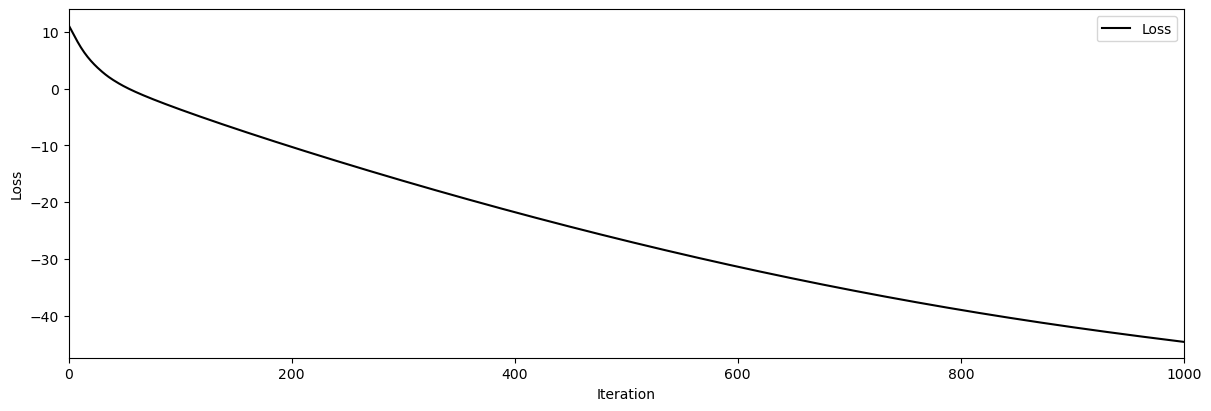

In [10]:
import mogptk  # pytorch >= 11.0 is required
import torch # pytorch 11.0 is used
import signatory # if cannot find a version compatible with pytorch, 
                 # install locally follows insturcction on https://github.com/patrick-kidger/signatory

mogptk.use_cpu()

#if torch.cuda.is_available():
#    mogptk.use_gpu(0)

model_life = 5
training_size = 0.95
Q = 3
init_method = 'BNSE'
method = 'Adam'

df2.loc[:,'time'] = np.linspace(0,1,len(df2)+model_life)[:len(df2)]
gpm_dataset = mogptk.LoadDataFrame(df2, x_col='time', y_col=names)
for channel in gpm_dataset:
    # normalize the path and fit the normalized path by y=a*t+b_t. The train would be performed on b_t 
    channel.transform(mogptk.TransformNormalize())
    channel.transform(mogptk.TransformDetrend())
for name in names:
    # remove the data after `training_size` as test data 
    gpm_dataset[name].remove_randomly(pct=1-training_size)

# set the model and train it
gpm = mogptk.SM_LMC(gpm_dataset, Q=Q,inference=mogptk.Exact())
gpm.init_parameters(init_method)
loss,error = gpm.train(method=method, lr=0.01, iters=1000, verbose=False,plot=True)

Note that here an additional compile time is included. 

In [11]:
import time
dim = 3
level = 3
word_concatenate_shuffle_dict = word_concatenate_shuffle(level,level)

# generate a list containing paths of each channels
X = gpm.sample(np.linspace(0,1,101),n=1000)
# rearrange the result into (number_of_paths,time_step+1,dim)
paths = np.concatenate([x.T.reshape(-1,100+1,1) for x in X],axis=2)
# normalize with the mean of the price at time 0
paths/= np.mean(paths[:,0],axis=0)

tensor_path = torch.tensor(paths,device='cuda:0')
# compute expected signature
signature = signatory.signature(tensor_path,level*2).mean(axis=0)
# add zero level to the signature
signature = np.concatenate([[1],np.array(signature.cpu())])

start0 = time.time()
# get coefficients of a^i_w in mean and variance functions 
mean_weights = np.array([integration_functional_coeff(signature,dim,level,i) for i in range(dim)]).reshape(1,-1)
var_coeff = get_sig_variance(signature,word_concatenate_shuffle_dict,dim,level)

# get coefficients of a^i_w in weights and weight sum functions 
weights_sum = get_weights_sum_coeff(signature,dim,level)
A = np.array([get_weights_coeff(signature,i,dim,level) for i in range(dim)])

print('time for getting coefficents(including compiling time):',time.time()-start0)

RuntimeError: The size of tensor a (303) must match the size of tensor b (3) at non-singleton dimension 1

In [ ]:
from scipy.optimize import minimize,LinearConstraint

exp_return = 0.05

object_function = lambda coeff: coeff.T@(var_coeff+np.eye(var_coeff.shape[0])*1e-5)@coeff

cons = ({'type': 'eq', 'fun': lambda coeff: np.squeeze(mean_weights)@coeff-exp_return},
                   {'type': 'eq', 'fun': lambda coeff: weights_sum@coeff-1},
                   LinearConstraint(A,lb=np.zeros(dim),ub=np.ones(dim)))

start = time.time()
res = minimize(object_function, np.ones(length_of_signature(dim,level)*3), method='SLSQP',
               constraints=cons)
print('time for optimisation:',time.time()-start)

Now we have a look at the optimised weight functional. Looks good! All weights are positive and the expected return is very close to our preset expected return.

In [ ]:
print('weights of each asset:',A@res.x) 
print('result portfolio variance:',res.x.T@var_coeff@res.x)
print('result portfolio expected return:',np.squeeze(mean_weights)@res.x)

### Section 4. Comparision of Previous Optimisation

A first important thing is to check whether the linear functionals obtained from two implements agrees. Then, the time for generating the linear functionals is recorded and compared. The signatures are both computed by `signatory.signature` on GPU.

In [ ]:
import torch
from src.optimisation.signature import ES
from src.signature_trading import _get_funcs

class RandomPathExpectedSignautre():
    model_life = np.infty
    def _get_paths(self,n,time_step,channel):
        self.paths = torch.rand(n,time_step+1,channel)
    
    def ExpectedSignature(self,level,transformation=None):
        return ES(self.paths,level)

In [ ]:
import unittest
import signatory
import time

word_concatenate_shuffle_dict = word_concatenate_shuffle(4,4)
class Test(unittest.TestCase):
    def __init__(self,dim,level):
        # get a set of random path and compute its expected signature
        res = RandomPathExpectedSignautre()
        res._get_paths(1000,100,dim)

        # generator functionals for old implementation
        start1 = time.time()
        get_funcs = _get_funcs(dim,level,res.ExpectedSignature)
        self.funcs = get_funcs.funcs
        print(f"time used for constructing linear functionals on paths with {dim} channels, trucated at level {level} with old implement:", 
                time.time()-start1)
        # generate coefficients for new implementation
        start2 = time.time()

        paths = res.paths.clone().detach().to('cuda:0')
        signature = signatory.signature(paths,(level+1)*2).mean(axis=0)
        signature = np.concatenate([[1],np.array(signature.cpu())])

        mean_weights = np.array([integration_functional_coeff(signature,dim,level+1,i) for i in range(dim)]).reshape(1,-1)
        var_coeff = get_sig_variance(signature,word_concatenate_shuffle_dict,dim,level+1)

        weights_sum = get_weights_sum_coeff(signature,dim,level+1)
        weights = np.array([get_weights_coeff(signature,i,dim,level+1) for i in range(dim)])

        self.funcs2 = [lambda coeff: coeff.reshape(-1,).T@(var_coeff-mean_weights.T@mean_weights)@coeff.reshape(-1,)]
        self.funcs2 += [lambda coeff: np.squeeze(mean_weights)@coeff.reshape(-1,),lambda coeff: weights_sum@coeff.reshape(-1,)]
        self.funcs2 += [lambda coeff: weights@coeff.reshape(-1,)]
        print(f"time used for constructing linear functionals on paths with {dim} channels, trucated at level {level} with new implement:", 
                time.time()-start2)

        self.coeff = np.random.random((dim,(dim**(level+1)-1)//(dim-1)))

    def test_variance(self):
        var1 = self.funcs[0](self.coeff)
        var2 = self.funcs2[0](self.coeff)
        self.assertAlmostEqual(var1,var2,8)

    def test_mean(self):
        mean1 = self.funcs[1](self.coeff)
        mean2 = self.funcs2[1](self.coeff)
        self.assertAlmostEqual(mean1,mean2,8)

    def test_weights_sum(self):
        weights_sum1 = self.funcs[2](self.coeff)
        weights_sum2 = self.funcs2[2](self.coeff)
        self.assertAlmostEqual(weights_sum1,weights_sum2,8)

    def test_weights(self):
        weights1 = self.funcs[3](self.coeff)
        weights2 = self.funcs2[3](self.coeff)
        for i,j in zip(weights1,weights2):
            self.assertAlmostEqual(i,j,8)

We can see that the new implementation is much faster than the old one (more than 300 times for 4-channel paths at truncated level 2 and almost 600 times for channel 3 level 3) with an error less than 1e-8. And we can see that the time used increases more rapidly when the truncated level and number of channel increases. Note that the functions are already compiled in jit, but this could always be achieved by pre compiling the code when loading the package, and the compile time is not too long in this case(no longer than 10s according to result in section 3).

In [ ]:
for dim,level in [(3,1),(3,2),(3,3),(4,2)]:
    test = Test(dim,level)
    test.test_variance()
    test.test_mean()
    test.test_weights_sum()
    test.test_weights()

### Reference:

[1] Owen Futter, Blanka Horvath, and Magnus Wiese. Signature trading: A path-dependent
extension of the mean-variance framework with exogenous signals. Available at SSRN 4541830,
2023